In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import files
uploads = files.upload()

Saving scraped_data.csv to scraped_data.csv


# Data Read

In [3]:
import csv

# Open the CSV file
with open('scraped_data.csv', newline='') as csvfile:
    # Create a CSV reader object
    csv_reader = csv.reader(csvfile)
    # Read each row into a list
    scraped_data_list = [row for row in csv_reader]

In [5]:

dfs = []
for scraped_data in scraped_data_list:
  scraped_data_lines = scraped_data.split("\n")
  data_values = [line.split('|') for line in scraped_data_lines]
  columns = data_values[0]
  df = pd.DataFrame(data_values[1:], columns=columns)

  dfs.append(df)


In [6]:
dfs = []
majority_sepsis_labels = []

for scraped_data in scraped_data_list:
    scraped_data_lines = scraped_data.split("\n")
    data_values = [line.split('|') for line in scraped_data_lines]
    columns = data_values[0]
    df = pd.DataFrame(data_values[1:], columns=columns)

    # Convert 'SepsisLabel' to numeric
    df['SepsisLabel'] = pd.to_numeric(df['SepsisLabel'])

    # Extract first 49 rows
    first_49_rows = df.head(49)

    # Calculate majority SepsisLabel value
    majority_sepsis_label = first_49_rows['SepsisLabel'].mode().iloc[0]

    dfs.append(df)
    majority_sepsis_labels.append(majority_sepsis_label)



# Data PreProcess

In [7]:
import numpy as np

updated_dfs = []
basic_data = []
parameters_size = 41
times_threshold = 49
max_times = 0

for df in dfs:
    value_array = []
    delta_array = []
    mask_array = []
    dataset = []

    last_available_times = np.zeros(parameters_size)
    count = 0

    for index, row in df.iterrows():
        count += 1
        values = row.values
        values = [0 if str(val) == 'NaN' else float(val) for val in values]

        deltas = np.zeros(parameters_size)
        mask = np.zeros(parameters_size)

        for i, value in enumerate(values):
            if not np.isnan(value):
                mask[i] = 1
                last_available_times[i] = count

        for i in range(parameters_size):
            deltas[i] = count - last_available_times[i]

        value_array.append(values)
        delta_array.append(deltas)
        mask_array.append(mask)

        if count == times_threshold:
          break

    while count < times_threshold:
        value_array.append(np.zeros(parameters_size))
        delta_array.append(np.zeros(parameters_size))
        mask_array.append(np.zeros(parameters_size))
        count += 1

    value_array = np.array(value_array).T
    delta_array = np.array(delta_array).T
    mask_array = np.array(mask_array).T

    dataset.append(value_array)
    dataset.append(mask_array)
    dataset.append(delta_array)
    updated_dfs.append(dataset)
    basic_data.append(value_array)

    max_times = max(max_times, count)




In [8]:
import copy
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

mice_dataset = copy.deepcopy(basic_data)
mice_dataset_np = np.array(mice_dataset)
mice_dataset_np_nan = np.where(mice_dataset_np == 0, np.nan, mice_dataset_np)
flattened_data = mice_dataset_np_nan.flatten()
imputer = IterativeImputer(n_nearest_features=10, skip_complete=True, min_value=0)
imputed_data = imputer.fit_transform(flattened_data.reshape(-1, 1))
imputed_dataset_np = imputed_data.reshape(mice_dataset_np_nan.shape)
imputed_dataset = imputed_dataset_np.tolist()

for i, data in enumerate(mice_dataset):
    for j in range(parameters_size):
        data[j] = imputed_dataset[i][j]

# Data split and loaders

In [9]:
import numpy as np

def custom_train_test_split(features, labels, test_size, validation_size=0.2, random_state=None):
  if random_state is not None:
    np.random.seed(random_state)

  # Shuffle indices
  indices = np.arange(len(features))
  np.random.shuffle(indices)

  # Calculate the number of test and validation samples
  n_test = int(len(features) * test_size)
  n_validation = int(len(features) * validation_size)

  # Split indices into test, validation, and train sets
  test_indices = indices[:n_test]
  validation_indices = indices[n_test:n_test + n_validation]
  train_indices = indices[n_test + n_validation:]

  # Split data based on indices
  test_data = [features[i] for i in test_indices]
  validation_data = [features[i] for i in validation_indices]
  train_data = [features[i] for i in train_indices]

  # Split labels based on indices
  test_labels = [labels[i] for i in test_indices]
  validation_labels = [labels[i] for i in validation_indices]
  train_labels = [labels[i] for i in train_indices]

  return train_data, train_labels, validation_data, validation_labels, test_data, test_labels

In [10]:
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):
  def __init__(self, features, labels) -> None:
    self.features = features
    self.labels = labels

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    sample = self.features[index]
    label = self.labels[index]
    sample = torch.tensor(sample, dtype=torch.float32)
    label = torch.tensor(label, dtype = torch.float32)
    return sample, label

In [11]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

def get_data_loader(dataset, labels_df):
  train_features, train_labels, validation_features, validation_labels, test_features, test_labels = custom_train_test_split(dataset, labels_df, test_size=0.2, validation_size = 0.15)

  print(len(train_features))
  print(len(train_labels))
  train_dataset = CustomDataset(train_features, train_labels)
  validation_dataset = CustomDataset(validation_features, validation_labels)
  test_dataset = CustomDataset(test_features, test_labels)

  train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)
  validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle = True)
  test_loader = DataLoader(test_dataset, batch_size = 4, shuffle = True)

  return train_loader, validation_loader, test_loader

In [12]:
mice_train_loader, mice_val_loader, mice_test_loader = get_data_loader(mice_dataset, majority_sepsis_labels)


# GRU Model

In [13]:
import torch
import torch.nn as nn

class MyGRU(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(MyGRU, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True)
    self.fc1 = nn.Linear(hidden_size, 50)
    self.dropout = nn.Dropout(0.2)
    self.fc2 = nn.Linear(50, 25)
    self.fc3 = nn.Linear(25, 1)
    self.relu = nn.ReLU()
    # self.sigmoid = torch.sigmoid()

  def forward(self, x):
    # h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size) * 0.01
    h0 = torch.normal(0, 0.01, size=(self.num_layers, x.size(0), self.hidden_size))
    out, _ = self.gru(x, h0)
    out = out[:, -1, :]
    out = self.fc1(out)
    out = torch.sigmoid(out)
    out = self.fc2(out)
    out = torch.sigmoid(out)
    out = self.fc3(out)
    out = torch.sigmoid(out)
    # out = torch.sigmoid(out)
    return out

# Train Model

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
lr = 0.01
momentum = 0.9
gamma = 0.1  # Factor by which to reduce the learning rate (e.g., multiply by 0.1)
num_layers = 4
input_size = 41
output_size = 1
hidden_dim = 30

model = MyGRU(input_size, hidden_dim, output_size, num_layers)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# optimizer = optim.Adam(model.parameters(), lr=0.05, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)  # Reduce LR by gamma factor every epoch
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, min_lr=1e-6, verbose=True)
class_weights = torch.tensor([0.7], dtype=torch.float)

loss_function = nn.BCEWithLogitsLoss(pos_weight=class_weights)
num_epochs = 10

def gru_train_model(train_loader, val_loader):

  for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()  # Set the model to training mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Training phase
    for inputs, labels in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs.permute(0, 2, 1)).squeeze()
      labels = labels.float().view(-1)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * inputs.size(0)

      train_predictions = (outputs > 0.5).float()
      correct_predictions += (train_predictions == labels).sum().item()
      total_samples += labels.size(0)

    # Calculate average training loss for the epoch
    train_loss = total_loss / len(train_loader.dataset)
    train_accuracy = correct_predictions / total_samples
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
      for val_inputs, val_labels in val_loader:
        val_outputs = model(val_inputs.permute(0, 2, 1)).squeeze()
        val_labels = val_labels.float().view(-1)
        val_loss += loss_function(val_outputs, val_labels).item() * val_inputs.size(0)

        # Calculate accuracy (optional)
        val_predictions = (val_outputs > 0.5).float()
        correct_predictions += (val_predictions == val_labels).sum().item()
        total_samples += val_labels.size(0)

    # Calculate average validation loss and accuracy
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct_predictions / total_samples

    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}")
    scheduler.step(val_loss)

In [ ]:
gru_train_model(mice_train_loader, mice_val_loader)

# Test Model

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
import torch

def gru_test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_probabilities = []  # Store probabilities for AUROC plotting

    with torch.no_grad():  # Disable gradient computation during inference
        for inputs, labels in test_loader:
            outputs = model(inputs.permute(0, 2, 1)).squeeze()  # Ensure output is a 1D tensor
            labels = labels.float().view(-1)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities < 0.5).float()  # Convert logits to binary predictions (0 or 1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)  # Increment total samples processed
            all_labels.extend(labels.tolist())
            all_probabilities.extend(probabilities.tolist())  # Use probabilities for ROC calculation

    accuracy = correct_predictions / total_samples
    auroc_score = roc_auc_score(all_labels, all_probabilities)  # Notice change here for probabilities
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"AUROC Score: {auroc_score:.4f}")

    # Generate classification report
    binary_predictions = [1 if prob < 0.5 else 0 for prob in all_probabilities]
    report = classification_report(all_labels, binary_predictions, target_names=['Class 0', 'Class 1'])
    print("Classification Report:\n", report)

    # Compute ROC curve and ROC area for plotting
    fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# You would call gru_test_model with your model and DataLoader instance.


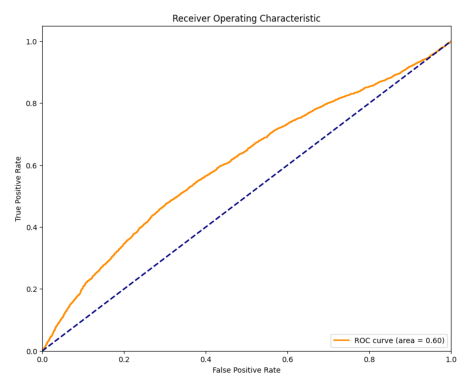

In [19]:


gru_test_model(model, mice_test_loader)